In [1]:
import os
import pandas as pd
import numpy  as np
from scipy.fft    import dct, idct
from scipy.signal import butter, savgol_filter, ellip, filtfilt, detrend
from matplotlib   import pylab as plt

## Load data

In [2]:
# paths were the preprocessed data is
root_path = 'data/'
data_path = os.path.join(root_path, 'Processed')
emg_path  = os.path.join(data_path, 'EMG')

# paths were the output should be
out_path = os.path.join(root_path, 'Running-happiness')

# check if the output folders exist and create them if necessary
for folder in [out_path]:
    if not os.path.exists(folder):
        os.mkdir(folder)

# list all files (ignoring the hidden macos file)
emg_files = [x for x in os.listdir(emg_path) if x.endswith('.csv')]
emg_files

['02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv',
 '03_EDA_SS2023_Exp1_Session1_Shimmer_86D4_Calibrated_SD.csv',
 '03_EMG_SS2023_Exp1_Session1_Shimmer_EC8E_Calibrated_SD.csv',
 '04_EMG_SS2023_Exp1_Session1_Shimmer_EC93_Calibrated_SD.csv']

In [3]:
df = pd.DataFrame()

for file in emg_files:
    filepath = os.path.join(emg_path, file)
    if df.empty:
        df       = pd.read_csv(filepath)
        df['participant'] = int(file.split('_')[0])
    else:
        tmp_df = pd.read_csv(filepath)
        tmp_df['participant'] = int(file.split('_')[0])
        df = df.append(tmp_df)

df.head()

,timestamp_UNIX,CH1,CH2,trial,participant
0,1.677476e+12,1.840104,3.233574,1,2
1,1.677476e+12,1.839839,3.233450,1,2
2,1.677476e+12,1.839578,3.233326,1,2
3,1.677476e+12,1.839319,3.233202,1,2
4,1.677476e+12,1.839063,3.233078,1,2


## Plot data

In [4]:
emg_files

['02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv',
 '03_EDA_SS2023_Exp1_Session1_Shimmer_86D4_Calibrated_SD.csv',
 '03_EMG_SS2023_Exp1_Session1_Shimmer_EC8E_Calibrated_SD.csv',
 '04_EMG_SS2023_Exp1_Session1_Shimmer_EC93_Calibrated_SD.csv']

In [5]:
df.head()

,timestamp_UNIX,CH1,CH2,trial,participant
0,1.677476e+12,1.840104,3.233574,1,2
1,1.677476e+12,1.839839,3.233450,1,2
2,1.677476e+12,1.839578,3.233326,1,2
3,1.677476e+12,1.839319,3.233202,1,2
4,1.677476e+12,1.839063,3.233078,1,2


In [6]:
df.tail()

,timestamp_UNIX,CH1,CH2,trial,participant
770229,1.677478e+12,-0.007724,-0.008098,33,4
770230,1.677478e+12,-0.011382,-0.012895,33,4
770231,1.677478e+12,-0.015068,-0.017727,33,4
770232,1.677478e+12,-0.018780,-0.022594,33,4
770233,1.677478e+12,-0.022519,-0.027497,33,4


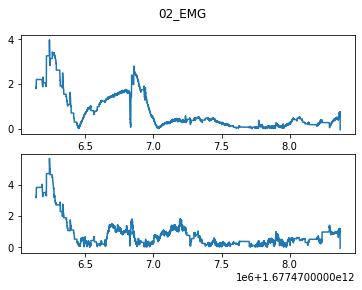

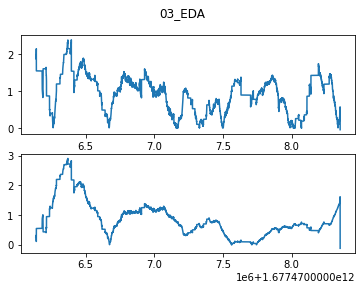

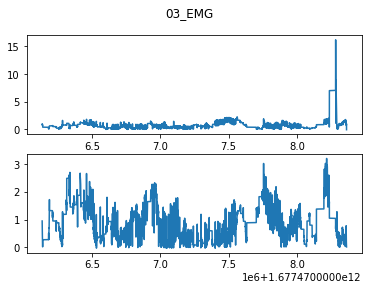

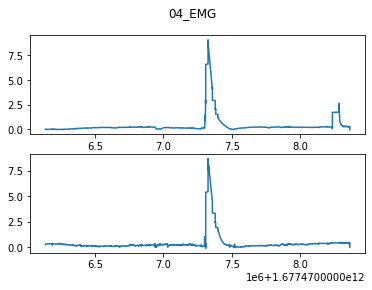

In [7]:
for file in emg_files:
    filepath = os.path.join(emg_path, file)
    df       = pd.read_csv(filepath)

    fig, ax = plt.subplots(2,1)
    ax[0].plot(df.timestamp_UNIX, df.CH1)
    ax[1].plot(df.timestamp_UNIX, df.CH2)
    plt.suptitle(file[:6])

## Normalize based on calibration

Average the maximal smile value and then divide each value by it. Then the measure should be mapped to speed.

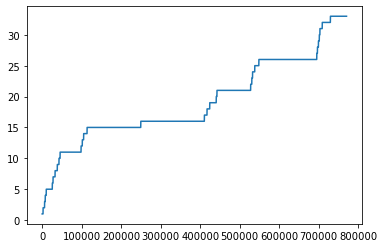

In [8]:
plt.plot(df.trial)

In [11]:
trial_calibration = 33


df.CH1[df.trial == trial_calibration]


729273    1.738564
729274    1.748244
729275    1.757900
729276    1.767532
729277    1.777141
            ...   
770229   -0.007724
770230   -0.011382
770231   -0.015068
770232   -0.018780
770233   -0.022519
Name: CH1, Length: 40961, dtype: float64

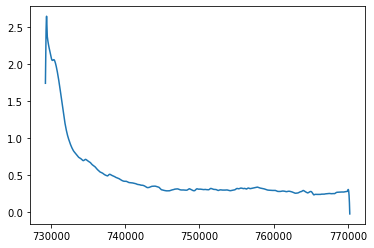

In [12]:
plt.plot(df.CH1[df.trial == trial_calibration])

In [13]:
df['label'] = 0

In [14]:
df.tail()

,timestamp_UNIX,CH1,CH2,trial,label
770229,1.677478e+12,-0.007724,-0.008098,33,0
770230,1.677478e+12,-0.011382,-0.012895,33,0
770231,1.677478e+12,-0.015068,-0.017727,33,0
770232,1.677478e+12,-0.018780,-0.022594,33,0
770233,1.677478e+12,-0.022519,-0.027497,33,0


In [37]:
df.trial == trial_calibration

0         False
1         False
2         False
3         False
4         False
          ...  
770229     True
770230     True
770231     True
770232     True
770233     True
Name: trial, Length: 770234, dtype: bool

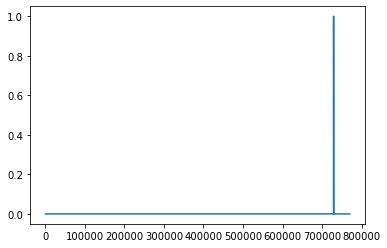

In [38]:
start_calibration = np.diff(df.trial == trial_calibration, n=1)
plt.plot(start_calibration)

In [39]:
start_calibration = np.argwhere(start_calibration)[0][0]

In [40]:
start_calibration

729272

In [43]:
fs = 512
duration = 5 # seconds
df.label[start_calibration:start_calibration + fs * duration] = 99

C:\Users\shigetou\AppData\Local\Temp/ipykernel_6936/1401567863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.label[start_calibration:start_calibration + fs * duration] = 99


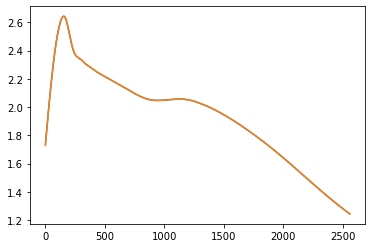

In [46]:
trial_calibration = 33

df.label[df.trial == trial_calibration] 

#512Hz, 5s = 512*5

s = 0
dfs = []
for a in (df.CH1[df.trial == trial_calibration]):
    s += 1
    dfs.append(a)
    if(s == 512*5):
        break
        
plt.plot(dfs)
plt.plot(df.CH1[start_calibration:start_calibration + fs * duration].values)

In [ ]:
trial_calibration = 15
for file in emg_files:


    trial_2_plot = 32
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(df.timestamp_UNIX[df.trial == trial_2_plot], df.CH1[df.trial == trial_2_plot])
    ax[1].plot(df.timestamp_UNIX[df.trial == trial_2_plot], df.CH2[df.trial == trial_2_plot])
    plt.suptitle(file[:6])

## Mapping to speed
Map the percentage of the maximum voluntary contraction (RMS in the calibration) done in every sample of the EMG

In [48]:
calibrationData = df.CH1[start_calibration:start_calibration + fs * duration].values

In [49]:
calibrationData.max()

2.6424250099438926

In [56]:
CH1_normalized = df.CH1 / calibrationData.max()

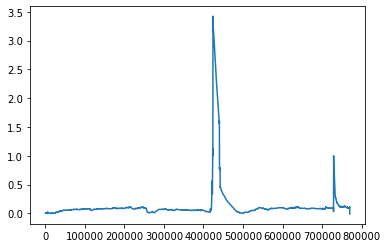

In [57]:
plt.plot(CH1_normalized)

In [60]:
CH1_normalized[CH1_normalized >= 0.5] = 0.5

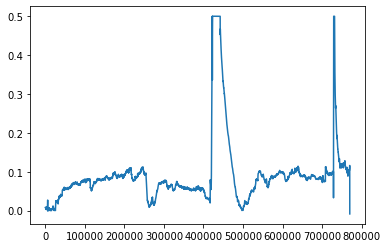

In [61]:
plt.plot(CH1_normalized)